<a href="https://colab.research.google.com/github/leticiaqs/puc-machine-learning/blob/main/MVP_deep_learning_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP_PARTE B - DEEP LEARNING

## Descrição do problema

A escolha de uma acomodação do Airbnb pode estar relacionada não só ao preço ou características básicas que ela oferece. Muitas vezes procuramos a opinião de quem já se hospedou em local para garantir que o local é realmente bom como o anúncio descreve. Por outro lado, isso faz com que justamente as acomodações ainda não avaliadas tenham que ser oferecidas por preços mais baixos e assim conseguir suas primeiras avaliações.

Pensando nisso, o problema parte da seguinte questão: e se fosse possível prever as avaliações de um local a partir da descrição do anfitrião? Será que é possível detectar somente pela descrição se um local é bom mesmo ou apenas mais ou menos?

Considerando essa questão, buscamos construir um modelo que - por meio de deep learning e processamento de linguagem natural (NLP)- consiga classificar uma acomodação (como o 'score' de uma avaliação) a partir de sua descrição.

Um modelo nesse sentido poderia então ajudar pobres viajantes (ou viajantes pobres!) a conseguir boas acomodações que não foram ainda avaliadas, mas pelo bom preço que elas oferecem.

### Características do Dataset

O dataset original(o mesmo utilizado na parte A do MVP) consiste em uma planilha que possui 106 colunas e 33715 entradas de dados (linha).

Cada linha corresponde a uma acomodação anunciada no Airbnb localizada no Rio de Janeiro, e cada coluna traz alguma informação/característica respectiva.
No entanto, faremos diversas transformações no dataset para que ele se adeque ao problema que estamos buscando solucionar e ao modelo pré-treinado (transformer) que será utilizado.

Assim, o dataset final possui apenas duas colunas, uma com a classe (relativa ao score de avaliação) em valores numéricos de 0 a 3 e, a coluna com textos os curtos de descrição da acomodação.

Dataset original disponível em: https://www.kaggle.com/datasets/leonardopena/rio-de-janeiro-brazil-airbnb-data

## Importação de bibliotecas

In [1]:
# para uso da GPU no Google Colab

import torch

torch.cuda.is_available() # verificando a ativação da GPU no notebook

False

In [2]:
# configuração para não exibir os warnings

import warnings
warnings.filterwarnings('ignore')

In [3]:
# tratamento e processamento dos dados

import pandas as pd
import numpy as np

In [4]:
# visualização e gráficos

import matplotlib.pyplot as plt
import seaborn as sn

In [5]:
# bibliotecas para load do dataset

!pip install gdown
import gdown
import os

In [6]:
# detecção de idioma

!pip install spacy_fastlang
import spacy_fastlang
import spacy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.4/780.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 9.4 MB/s eta 0:00:00
ERROR: Operation cancelled by user
  Preparing metadata (setup.py) ... 

ModuleNotFoundError: ignored

In [ ]:
# detecção de idioma - 2ª opção

!pip install langdetect
from langdetect import detect

In [ ]:
# barra de progresso e diagnóstico

!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
from tqdm import tqdm

In [21]:
# install transformers

!pip install transformers[torch] datasets evaluate scikit-learn

# para dataset no formato lido pelo transformer 'hugging faces'
from datasets import load_dataset



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.7 MB/s eta 0:00:00


In [ ]:
# modelos pré-treinados e tokenizers

from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [ ]:
# import do trainer e algoritmo para métricas de avaliação

from transformers import Trainer, TrainingArguments
import evaluate

In [ ]:
# padding dinâmico

from transformers import DataCollatorWithPadding

## Load do dataset

In [7]:
# Traz o arquivo do google drive para uma pasta local do notebook

file_id = '1J9graB1znI40eB_58haxlN9gwNCeJFaS'
url = f'https://drive.google.com/uc?id={file_id}'

folder_path = './dataset'
os.makedirs(folder_path, exist_ok=True)

output = 'dataset/airbnb_raw.csv'
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=1J9graB1znI40eB_58haxlN9gwNCeJFaS
To: /content/dataset/airbnb_raw.csv
100%|██████████| 112M/112M [00:02<00:00, 43.1MB/s]


'dataset/airbnb_raw.csv'

In [ ]:
# leitura do csv

def load_raw_data() -> pd.DataFrame:
  return pd.read_csv('/content/dataset/airbnb_raw.csv')

dataset = load_raw_data()


Para visualização de como está configurado o dataset original, podemos usar:



```
dataset.head()
```



## Pré-processamento dos dados

Para este problema, restringiremos o dataset apenas às colunas de interesse: 'description' e 'review_scores_rating'. Também faremos a transformação dos scores em 4 classes, constituindo um problema de classificação. Também serão excluídas as acomodações que não possuem avaliações, uma vez que elas contribuem para o treinamento do modelo.

### Redução do número de colunas (features)

Para agilizar o processo de limpeza do dataset, reduziremos o número de colunas, restringindo-o apenas àquelas que representam informações importantes para o pré-processamento e posterior treinamento do modelo.

Nesse ponto, também já removeremos as entradas referentes a acomodações que não foram ainda avaliadas, evitando ruído para treinamento do modelo.

In [ ]:
def selection_base_dataset(df: pd.DataFrame) -> pd.DataFrame:

  # remoção das acomodações ainda não avaliadas
  df_reduced = df.loc[~(df['number_of_reviews'].isin([0]))]

  # pré-seleção de features do dataset:
  return df_reduced[[
      'description',
      'review_scores_rating',
  ]].copy()

In [ ]:
dataset_selection = selection_base_dataset(dataset)

### Remoção de entradas nulas (vazio)

Assim como no processamento utilizando algoritimos de Machine Learning clássico, também é necessário remover entradas vazias (dados faltantes) para um aprendizado mais preciso.

In [ ]:
# contabilizando entradas null

dataset_selection.isna().sum()

description             320
review_scores_rating    858
dtype: int64

In [ ]:
# tratamento de dados faltantes

def valid_base_dataset(df: pd.DataFrame) -> pd.DataFrame:

  df_temp = df.copy()

  return df_temp.dropna()

In [ ]:
valid_dataset = valid_base_dataset(dataset_selection)

### Transformação 'scores' em classes

A pontuação de avaliação das acomodações pode assumir valores inteiros de 0 a 100. Para uma melhor leitura dentro do problema proposto, uma solução é a agregação desses 'scores' em um número menor de classes, facilitando a interpretação também das futuras predições do modelo. Com isso convertemos o problema em uma questão de classificação.

#### 1) Avaliação da distribuição

Em uma primeira etapa, é necessário entender como estão distribuídos os valores de pontuação no dataset, para entendermos qual a melhor forma de criar as novas classes.

<Axes: xlabel='review_scores_rating', ylabel='Count'>

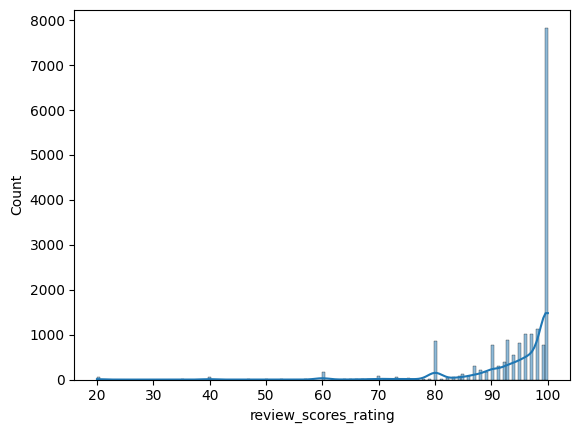

In [ ]:
# histograma das pontuações

sn.histplot(valid_dataset['review_scores_rating'], kde=True)

In [ ]:
# leitura da distribuição por quartis

valid_dataset['review_scores_rating'].describe()

count    18007.000000
mean        94.815849
std          8.978065
min         20.000000
25%         93.000000
50%         98.000000
75%        100.000000
max        100.000000
Name: review_scores_rating, dtype: float64

A partir da análise da distribuição dos scores, percebemos um desbalanceamento do dataset, o que pode gerar duas possibilidades de interpretação dentro do problema colocado: (i) os usuários do Airbnb costumam dar notas muito altas, o que faz com que mesmo acomodações que não sejam tão boas recebam scores acima de 90; ou (ii) trata-se apenas de um dataset desbalanceado, o que poderá dificultar a precisão do modelo.

#### 2) Criação das classes

Considerando a avaliação realizada na etapa anterior, decidimos optar pela primeira interpretação da questão. Com isso, foram definidas 5 classes, atribuídas conforme os valores identificados nos quartis da distribuição.

In [ ]:
# simplificação dos scores em 5 classes

def labeled_dataset(df: pd.DataFrame) -> pd.DataFrame:

  df_classes = df.copy().reset_index()

  # atribuição de label de classe aos 'scores'
  label = pd.Series([0] * len(df_classes))
  thresholds = [93, 98, 100]

  for th in thresholds:
    label = label + (df_classes['review_scores_rating'] >= th).astype(int)

  df_classes['label'] = label

  return df_classes.drop(columns='index')

In [ ]:
classes_dataset = labeled_dataset(valid_dataset)

classes_dataset.tail(10)

,description,review_scores_rating,label
17997,"Apart hotel frente praia da Barra, RECEPÇAO 2...",100.0,3
17998,"Apartamento com cara de casinha industrial, co...",100.0,3
17999,"Studio em Copacabana, dividido em sala e quart...",100.0,3
18000,"Apartamento com decoração hipster, com catálog...",100.0,3
18001,Apartamento para uso inteiro com sala dois qua...,100.0,3
18002,Quarto com cama de solteiro e uma auxiliar que...,100.0,3
18003,"Apartamento moderno, suíte com uma cama Queen....",100.0,3
18004,"Apartamento aconchegante, conta com aproximada...",80.0,0
18005,Lindo e aconchegante Studio recém reformado. A...,100.0,3
18006,. Os espaços disponíveis para uso dos hóspedes...,100.0,3


### Simplificação do formato do dataset

O transformer que será utilizado necessita um formato específico de dataset para a predição. Com isso, ele adota um formato simplificado em que constam apenas os rótulos (classes) e o texto a ser classificado. Dessa forma foi necessária a adequação do dataset a esse modelo.

In [ ]:
def simple_base_dataset(df: pd.DataFrame) -> pd.DataFrame:

  # seleção de colunas
  simple_dt = df[['description', 'label']].copy()

  # renomeando coluna target para label
  simple_dt = simple_dt.rename(columns={'description': 'text'})

  # inverte ordem das colunas para formato adotado no modelo
  return simple_dt[['label', 'text']]


In [ ]:
airbnb = simple_base_dataset(classes_dataset)

In [ ]:
airbnb.head()

,label,text
0,1,Pls note that special rates apply for Carnival...
1,1,"Our apartment is a little gem, everyone loves ..."
2,1,This nice and clean 1 bedroom apartment is loc...
3,1,This cosy apartment is just a few steps away ...
4,2,Our newly renovated studio is located in the b...


In [ ]:
airbnb.to_csv('/content/dataset/prepro_airbnb.csv',index=False)

## Preparação para o treinamento

Nessa seção, faremos as transformações necessárias dos dados do dataset para que ele possa ser utilizado no treinamento

In [14]:
# 'chama' o arquivo no Google Drive:
file_id = '1bEBWQCwZKvWFx-34xjHZ1Wi1-YN1M--z'
url = f'https://drive.google.com/uc?id={file_id}'

folder_path = './dataset'
os.makedirs(folder_path, exist_ok=True)

output = 'dataset/prepro_airbnb.csv'
gdown.download(url, output)

# leitura do csv
def load_preprocessed() -> pd.DataFrame:
  return pd.read_csv('/content/dataset/prepro_airbnb.csv')

airbnb = load_preprocessed()

Downloading...
From: https://drive.google.com/uc?id=1bEBWQCwZKvWFx-34xjHZ1Wi1-YN1M--z
To: /content/dataset/prepro_airbnb.csv
100%|██████████| 14.0M/14.0M [00:00<00:00, 45.4MB/s]


### Split de treino e teste

In [15]:
# split treino e teste
def train_test (df: pd.DataFrame, train_file, test_file):
  train = df.sample(random_state=21, frac = 0.70) # separando 70% para treino
  test = df.drop(train.index) # deixando os restante 30% para teste

  # gerando respectivos csv's locais
  train.to_csv(train_file,index=False)
  test.to_csv(test_file,index=False)


In [16]:
train_test(airbnb, 'train.csv','test.csv')

O modelo escolhido exige um formato específico de dataset, que é o adotado na biblioteca 'hugging faces'. Uma vez que estamos trabalhando com um dataset externo, torna-se necessária a sua conversão para o formato adequado.

In [22]:
def load_train_test(train: str, test: str):
  data_airbnb = load_dataset('csv', data_files={'train': train, 'test': test},
                              column_names=['label', 'text'], skiprows=[0])

  # indica pro trainer saber qual a coluna precisa aprender a predizer
  return data_airbnb.class_encode_column(column='label')

In [23]:
airbnb_dataset = load_train_test('train.csv','test.csv')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-025d27b08cf79e49/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Stringifying the column:   0%|          | 0/12605 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/12605 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/5402 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/5402 [00:00<?, ? examples/s]

In [ ]:
# conferência das classes existentes no dataset

set(airbnb_dataset['train']['label'])

{0, 1, 2, 3}

Para o treinamento de uma rede profunda, o emprego de um método de cross validation tomaria um longo tempo de processamento para ganhos não tão significativos. Por isso, não faremos separação de folds no dataset de treino nesse caso.

### Validação

Não sendo realizada a 'cross validation', cabe então a separação de dados para a validação, para que possamos verificar a priori se houve algum tipo de overfitting no treinamento. Assim, poderemos fazer ajustes antes de empregar o modelo para a predição no dataset de teste.

In [ ]:
# separação treino e validação em datasets menores
def sample_dataset(dt):
  train = dt['train'].shuffle(seed=21).select(range(500))
  val = dt['train'].shuffle(seed=21).select(range(500,650)) # validação
  return train, val

In [ ]:
train_dataset, val_dataset = sample_dataset(airbnb_dataset)

Para fazer as primeiras avaliações do modelo, considerando o tempo de processamento necessário, empregaremos apenas uma pequena amostra do dataset, conforme amostra separada na celula anterior.

No entanto, sabe-se que os resultados de acurácia podem ser diretamente afetados por isso, de maneira que será então utilizado todo o dataset de treino no treinamento do modelo final.

### Tokenização

Chamaremos aqui de tokenização o processo necessário de transformação do texto em vetores numéricos, formato que então poderá ser lido pelo modelo pré-treinado. Trata-se de uma etapa fundamental no processamento de linguagem natural.

In [ ]:
# carga do tokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [ ]:
# transformação de palavras em vetores/números

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

O tokenizer utilizado é baseado no modelo BERT-cased (diferencia tokens para palavras em caixa alta e caixa baixa), já pré-treinado.

## Treinamento 1

### Escolha do Modelo

***Tranformer:***  Hugging Faces - Auto Model For Sequence Classification

***Modelo:*** BERT-cased (english)

Pela complexidade envolvida em um problema de processamento de linguagem natural, o uso de transformers se coloca como estado da arte no contexto atual.

Considerando a co-dependência existente entre as partes do texto, entende-se que uma melhor solução para esse tipo de problema envolva, pelo menos, o uso rede neural recorrente. Com isso, o modelo se torna capaz de 'entender' o contexto das frases e não apenas palavras isoladas.
Dadas as inovações trazidas pela arquitetura 'Attention', sobretudo no quesito de apreensão de contexto, optamos então por utilizar um modelo do tipo 'BERT-based', já pré-treinado com um grande volume de textos. Esse mecanismo também vem se mostrando bastante eficiente em textos curtos, como é o caso do dataset em questão.

Também se entende que, esse tipo de modelo possui melhor desempenho no aprendizado com textos curtos, quando comparado a outros tipos de RNN, como uma rede LSTM mais simples. O tipo de texto utilizado nas descrições do Airbnb, além de curtos, possuem ainda muito ruído (símbolos e caracteres), somado a linguagem informal na maioria dos casos. O modelo escolhido também é reconhecido por lidar bem com dados dessa natureza, sendo bastante empregado em datasets de textos como reviews de filmes, etc.

Outra vantagem da utilização de transformers está relacionada à preparação do texto. Nesse caso, apesar das adequações feitas no dataset, não se faz necessária a realização de procedimentos como a remoção de stop-words, stemmização ou embedding, pois o transformer já inclui esses procedimentos no processamento e tokenização.

Com isso, é necessário apenas indicar o modelo de tokenizer e seus respectivos hiperparâmetros para a transformação dos dados, tal qual realizado na etapa anterior.

In [ ]:
# carga do modelo pré-treinado

model1 = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Fine Tuning

Tratando-se de um modelo pré-treinado, o que será feito neste caso é o treinamento do modelo para que ele seja capaz de melhor classificar os textos relacionados a este problema específico das descrições do Airbnb.

#### Ajuste inicial de parâmetros

O modelo permite o ajuste de alguns hiperparametros que podem contribuir para o melhor desempenho do modelo. Nesse primeiro momento trabalharemos com os seguintes:

***- batch size:*** indicamos inicialmente que cada passo ('step') seja composto de 4 amostras

***- number of epochs:*** estabelecemos que todo o dataset será visto pelo modelo 2 vezes (2 épocas)

***- logging steps:*** o modelo deve registrar as métricas de treinamento e validação a cada 5 steps - para que possamos registrar a acurácia em diversos momentos do treinamento, conseguindo capturar o melhor resultado.

O ajuste inicial priorizou dar certa agilidade para um primeiro treinamento, tendo sido também realizadas algumas experimentações previamente (tentativa e erro). Assim, os valores adotados combinam a melhor acurácia conseguida com menor tempo de treinamento.

In [ ]:
# configuração da métrica

metric = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:

model_path = 'bert_modelo1_airbnb'

training_args = TrainingArguments(
    output_dir= model_path,
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy='steps',
    save_strategy='steps',
    logging_strategy='steps',
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    disable_tqdm=False
)

In [ ]:
trainer = Trainer(
    model=model1,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
5,1.631700,1.409606,0.280000
10,1.399000,1.320714,0.373333
15,1.372700,1.329614,0.406667
20,1.118800,1.372248,0.366667
25,1.156900,1.414150,0.400000
30,1.220300,1.434922,0.393333
35,1.257700,1.359866,0.406667
40,1.236400,1.321873,0.406667
45,1.347000,1.313097,0.406667
50,1.066000,1.374133,0.406667


TrainOutput(global_step=250, training_loss=1.292778974533081, metrics={'train_runtime': 152.0694, 'train_samples_per_second': 6.576, 'train_steps_per_second': 1.644, 'total_flos': 263115780096000.0, 'train_loss': 1.292778974533081, 'epoch': 2.0})

In [ ]:
# cria dataframe de resultados
df_log = pd.DataFrame(trainer.state.log_history)

In [ ]:
# salva o modelo treinado
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

### Avaliação da etapa

<Axes: >

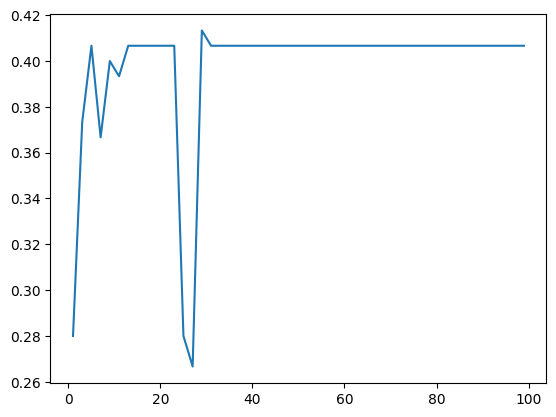

In [ ]:
df_log = pd.DataFrame(trainer.state.log_history)

df_log['eval_accuracy'].dropna().plot()

<Axes: >

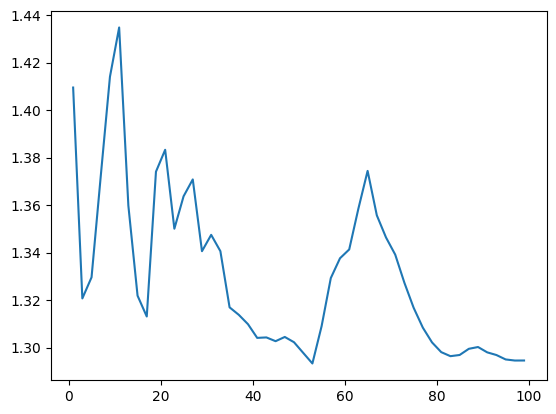

In [ ]:
df_log['eval_loss'].dropna().plot()

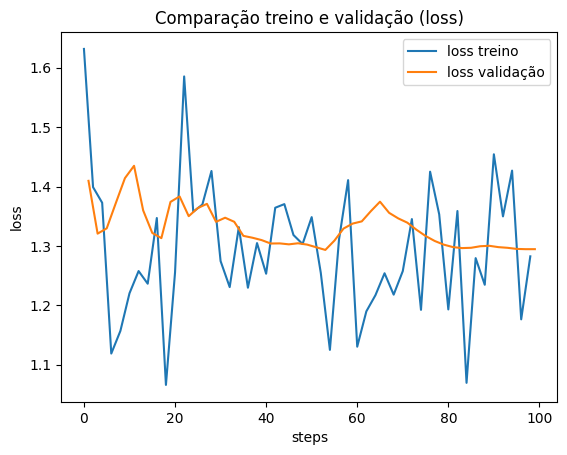

In [ ]:

plt.plot((df_log['loss'].dropna()), label='loss treino')
plt.plot((df_log['eval_loss'].dropna()), label='loss validação')


# # Customize the chart (optional)
plt.title('Comparação treino e validação (loss)')
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()

plt.show()

Nesse primeiro trenamento, o modelo apresentou uma acurácia relativamente baixa, comparada ao que se tem visto em outros projetos utilizando esse mesmo tipo de modelo para classificação.

Por outro lado, há quatro classes possíveis no dataset, o que mostra que o modelo teve um desempenho melhor do que se estivéssemos chutando aleatoriamente, ou seja, maior que 25%.

Além disso, 'loss' de treino e validação, apesar de variarem de maneira bem distinta, a diferença entre eles não é suficiente para indicar um overfitting do treinamento.

## Treinamento 2

A partir dos resultados encontrados no primeiro treinamento, buscou-se avaliar algumas características dos dados contidos no dataset que pudessem dar pistas sobre os resultados encontrados, além transformações que resultassem em uma melhora de desempenho.

### Identificação de idiomas no dataset

Como primeira questão levantada, para o modelo utilizado, o idioma dos textos precisa ser o mesmo do pré-treinamento, a fim de alcançar bons resultados. Idiomas distintos podem gerar ruído no tokenizador e, por consequencia no aprendizado do modelo.

A detecção de idioma é um problema comumente resolvido também por meio de redes profundas de processamento de linguagem natural. Testaremos aqui duas opções de modelos pré-treinados, com respectivas vantagens e desvantagens.

Obs.: caso essa operação seja feita em outro momento, podemos pular a etapa de pré-processamento dos dados fazendo o upload do dataset utilizando o código abaixo.

```
# 'chama' o arquivo no Google Drive:
file_id = '1bEBWQCwZKvWFx-34xjHZ1Wi1-YN1M--z'
url = f'https://drive.google.com/uc?id={file_id}'

folder_path = './dataset'
os.makedirs(folder_path, exist_ok=True)

output = 'dataset/prepro_airbnb.csv'
gdown.download(url, output)

# leitura do csv
def load_preprocessed() -> pd.DataFrame:
  return pd.read_csv('/content/dataset/prepro_airbnb.csv')

airbnb = load_preprocessed()
```



#### 1) SpaCy FastLang
Esse modelo pré-treinado faz parte da biblioteca SpaCy, que é bastante utilizada para problemas de NLP. No entanto, o modelo possui tempo de resposta alto, além de apresentar menor acurácia em textos curtos. Pela natureza dos textos das descrições do Airbnb, os resultados podem não ser tão precisos.

In [ ]:
# dectecção de idiomas SpaCy FastLang
nlp = spacy.load("en_core_web_sm")

nlp.add_pipe('language_detector')

def detect_language(text):
    doc = nlp(text)
    return doc._.language

df_spacy = airbnb.copy()

tqdm.pandas(desc='Progress')

#criação de coluna identificadora do idioma
df_spacy['language'] = df_spacy['text'].progress_apply(detect_language)


Progress: 100%|██████████| 18007/18007 [11:38<00:00, 25.79it/s]


In [ ]:
df_spacy['language'].value_counts()

pt    10759
en     6960
es      134
fr       74
de       40
it       27
nl        3
ja        3
ru        3
no        1
sv        1
fi        1
cs        1
Name: language, dtype: int64

In [ ]:
# salvando dataset com rótulos de idioma (SpaCy FastLang)

# cria pasta auxiliar
new_folder = './dataset/aux'
os.makedirs(new_folder, exist_ok=True)

df_spacy.to_csv('/content/dataset/aux/airbnb_spacy_fastlang.csv',index=False)

#### 2) Python LangDetect
Nesse modelo desenvolvido em python temos um detector de idiomas que costuma ter melhor desempenho em textos curtos como no caso do dataset em questão. Além disso, o modelo possui um processamento mais rápido. No entanto, ele retorna erro nas entradas cujo formato não está em acordo com o seu formado do pré-treinamento.

In [ ]:
def detect_language(text):
  try:
    return detect(text)
  except:
    return None # retorna vazio para as entradas fora do formato de leitura

df_langdetect = airbnb.copy()

tqdm.pandas(desc='Progress')

#criação de coluna identificadora do idioma
df_langdetect['language'] = df_langdetect['text'].progress_apply(detect_language)

df_langdetect = df_langdetect.dropna() # remove as entradas 'null' (não detectadas pelo langdetect)


Progress: 100%|██████████| 18007/18007 [02:17<00:00, 130.95it/s]


In [ ]:
print(len(df_langdetect))

df_langdetect['language'].value_counts()

18004


pt    10575
en     7181
es      104
fr       70
de       33
it       30
tl        3
id        2
ja        1
no        1
ru        1
sv        1
ca        1
fi        1
Name: language, dtype: int64

Caso não seja criada a pasta auxiliar da etapa anterior ao salvar o dataset rotulado utilizando Spacy FastLang, será necessário cria-la nesse momento, utilizando o código abaixo:



```
# caso a pasta não tenha sido criada ainda

new_folder = './dataset/aux'
os.makedirs(new_folder, exist_ok=True)
```



In [ ]:
# salvando dataset com rótulos de idioma (Pyhton langdetect)

df_langdetect.to_csv('/content/dataset/aux/airbnb_python_langdetect.csv',index=False)


#### Solução adotada

Os resultados se mostraram próximos nos dois métodos. Entretanto, consideraremos o modelo com processamento mais rápido. Além disso, vê-se como vantagem a remoção das entradas que apresentariam erro no caso do modelo LangDetect, pois se tratavam de entradas vazias não detectadas no processo de limpeza anterior - que também poderiam prejudicar o treinamento.

### Separação de datasets por idioma


Após a identificação realizada, percebemos que o dataset possui entradas de diferentes idiomas, especialmente português e inglês. Dado que cada modelo classificador é treinado apenas em único idioma, para melhores resultados, torna-se necessário dois modelos, cada um com o fine tune realizado com o dataset do respectivo idioma de pré-treinamento.

In [ ]:
# dataset com entradas em português
language = ['pt','en']
lang_dataset = {}

for lang in language:
  df_lang = df_langdetect.loc[df_langdetect['language'] == lang]
  lang_dataset[lang] = df_lang[['label', 'text']].copy()

airbnb_pt = lang_dataset['pt']
airbnb_en = lang_dataset['en']

### Preparação para treinamento

Faremos então a preparação do dataset com as entradas em inglês para um novo treinamento do modelo. A seguir, faremos as mesmas etapas de preparo utilizadas no modelo anterior.

In [ ]:
# separação treino e test (70% e 30%)

train_test(airbnb_en, 'train_en.csv', 'test_en.csv')

In [ ]:
# load dos datasets no formato adequado
airbnb_data_en = load_train_test('train_en.csv','test_en.csv')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-88508f41fa286ac0/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Stringifying the column:   0%|          | 0/5021 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/5021 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/2152 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/2152 [00:00<?, ? examples/s]

In [ ]:
# separação treino e validação em datasets menores
airbnb_train_en, airbnb_val_en = sample_dataset(airbnb_data_en)

In [ ]:
# tokenização

tokenized_train_en = airbnb_train_en.map(tokenize_function, batched=True)
tokenized_val_en = airbnb_val_en.map(tokenize_function, batched=True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

### Fine-tunning

In [ ]:
# carga do modelo pré-treinado

model2 = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# estabelecendo parâmetros

model_path = 'bert_modelo2_en_airbnb'

training_args = TrainingArguments(
    output_dir= model_path,
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy='steps',
    save_strategy='steps',
    logging_strategy='steps',
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    disable_tqdm=False
)

In [ ]:
trainer = Trainer(
    model=model2,
    args=training_args,
    train_dataset=tokenized_train_en,
    eval_dataset=tokenized_val_en,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
5,1.356600,1.399838,0.280000
10,1.378000,1.377839,0.306667
15,1.290200,1.374642,0.320000
20,1.245300,1.385910,0.286667
25,1.192000,1.393271,0.286667
30,1.449300,1.389908,0.286667
35,1.284500,1.398016,0.300000
40,1.310100,1.388588,0.306667
45,1.408300,1.397596,0.326667
50,1.115300,1.425853,0.326667


TrainOutput(global_step=250, training_loss=1.3202190647125245, metrics={'train_runtime': 137.0027, 'train_samples_per_second': 7.299, 'train_steps_per_second': 1.825, 'total_flos': 263115780096000.0, 'train_loss': 1.3202190647125245, 'epoch': 2.0})

In [ ]:
# cria um dataframe de resultados
df_log2 = pd.DataFrame(trainer.state.log_history)

In [ ]:
# salva o modelo treinado
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

### Avaliação da etapa

<Axes: >

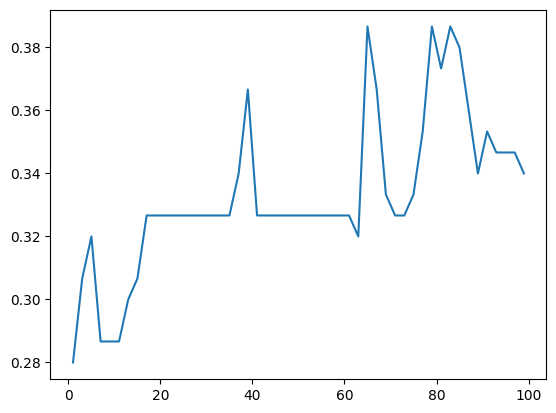

In [ ]:
df_log2['eval_accuracy'].dropna().plot()

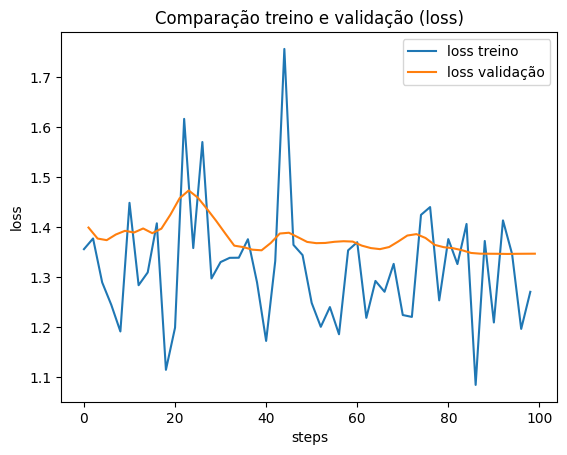

In [ ]:
plt.plot((df_log2['loss'].dropna()), label='loss treino')
plt.plot((df_log2['eval_loss'].dropna()), label='loss validação')


# # Customize the chart (optional)
plt.title('Comparação treino e validação (loss)')
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()

plt.show()

Utilizando o dataset de entradas somente em inglês, ao contrário do esperado, observamos uma piora no resultado da acurácia do modelo. Tal diferença pode ter relação com a parcela do dataset separado para treino, que pode conter textos mais difíceis para a predição. Nesse caso, também foi observada uma certa tendência ao overfitting (embora não chegue a caracterizar como tal), onde a diferença entre o loss de treino e validação chegou a valores maiores.

Podemos supor também que questão da baixa acurácia está associada ao modelo utilizado em si, ou à configuração dos hiperparâmetros.

##Treinamento 3

Para tentar então superar os resultados obtidos anteriormente, testaremos outro modelo, também baseado na arquitetura BERT, porém com alguns fatores de otimização de desempenho.



**Modelo escolhido:** XLM - RoBERTa ( Robustly Optimized BERT Pretraining Approach )

O modelo traz algumas otimizações em relação ao anterior, especialmente no que diz respeito à tokenização.

Também traz alguns outras melhorias do pré-treinamento, como o uso de diferentes idiomas, o que pode ser bastante útil para treinarmos o dataset em questão sem a necessidade de separação nos idiomas específicos, diminuindo a quantidade de dados.

In [ ]:
# carga do tokenizer

tokenizer_roberta = AutoTokenizer.from_pretrained('xlm-roberta-base')

In [ ]:
# transformação de palavras em vetores/números

def tokenize_roberta(examples):
    return tokenizer_roberta(examples['text'], truncation=True)

tokenized_train_roberta = train_dataset.map(tokenize_roberta, batched=True)
tokenized_val_roberta = val_dataset.map(tokenize_roberta, batched=True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Uma outra estratégia que tentaremos aplicar é a de padding dinâmico. Em lugar da estratégia de padding pelo máximo tamanho. Nesse sentido, a 'leitura' das frases pelo modelo pode resultar mais eficiente, embora mais lenta em termos de processamento, pois teremos batches de diferentes tamanhos.

In [ ]:
# padding dinâmico

data_collator = DataCollatorWithPadding(tokenizer=tokenizer_roberta)

### Modelagem

In [ ]:
# carga do modelo pré-treinado

model3 = AutoModelForSequenceClassification.from_pretrained(
    'xlm-roberta-base',
    num_labels=4
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Para esse treinamento, visando a comparação dos modelos, adotaremos os mesmos hiperparâmetros utilizados anteriormente.

In [ ]:
# definindo hiperparâmetros

model_path = 'roberta_modelo1_airbnb'

training_args = TrainingArguments(
    output_dir= model_path,
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy='steps',
    save_strategy='steps',
    logging_strategy='steps',
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    disable_tqdm=False
)



In [ ]:
# inserindo parâmetros definidos no trainer

trainer = Trainer(
    model=model3,
    args=training_args,
    train_dataset=tokenized_train_roberta,
    eval_dataset=tokenized_val_roberta,
    tokenizer=tokenizer_roberta,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy
5,1.360300,1.373330,0.280000
10,1.446800,1.350546,0.406667
15,1.383200,1.337175,0.406667
20,1.269400,1.320522,0.406667
25,1.275700,1.441350,0.380000
30,1.283200,1.481852,0.313333
35,1.235800,1.306489,0.406667
40,1.221200,1.308221,0.406667
45,1.358600,1.317105,0.406667
50,1.170300,1.439432,0.406667


TrainOutput(global_step=250, training_loss=1.3112771091461182, metrics={'train_runtime': 73.3496, 'train_samples_per_second': 13.633, 'train_steps_per_second': 3.408, 'total_flos': 130197088122816.0, 'train_loss': 1.3112771091461182, 'epoch': 2.0})

In [ ]:
df_log3 = pd.DataFrame(trainer.state.log_history)

In [ ]:
#salva o modelo treinado
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('roberta_modelo1_airbnb/tokenizer_config.json',
 'roberta_modelo1_airbnb/special_tokens_map.json',
 'roberta_modelo1_airbnb/vocab.txt',
 'roberta_modelo1_airbnb/added_tokens.json',
 'roberta_modelo1_airbnb/tokenizer.json')

### Avaliação da etapa

<Axes: >

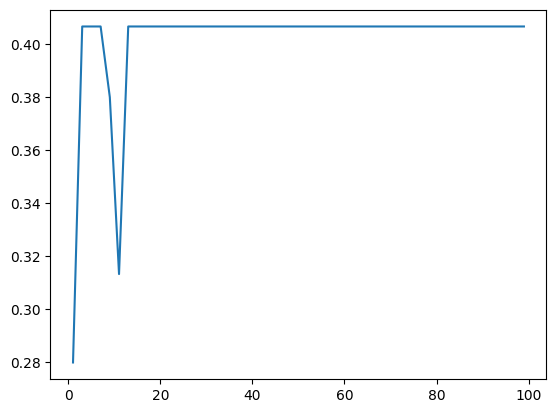

In [ ]:
df_log3['eval_accuracy'].dropna().plot()

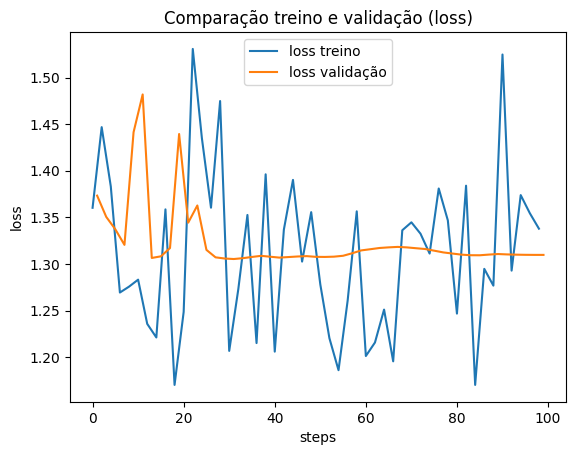

In [ ]:
# plot loss treino x loss validação
plt.plot((df_log3['loss'].dropna()), label='loss treino')
plt.plot((df_log3['eval_loss'].dropna()), label='loss validação')

plt.title('Comparação treino e validação (loss)')
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()

plt.show()

Os resultados obitidos com o novo modelo mostraram um desempenho muito próximo do primeiro treinamento, porém com menor tendência ao overfitting.

Porém de modo global, a acurácia - abaixo de 0,50 - traz ainda um grande índice de erros na predição, ainda que se mostre melhor que um chute aleatório.
No entanto, recorda-se o treinamento vem sendo realizado com uma pequena parcela do dataset, em que se espera uma melhor acurácia ao treinar com o dataset completo. Além disso, não foram feitos ajustes nos hiperparâmetros para que o modelo superasse, por exemplo, a constante da acurácia observada ao longo do treinamento.

## Modelo Final

Apesar da diferença entre os resultados não ter sido significativa, adotaremos o transformer XLM - RoBERTa como modelo final, pois há um potencial de melhora considerável se alterarmos seus hiperparâmetros.

Assim faremos a otimização de hiperparâmetros, buscando ainda uma melhora de performance.

Utilizaremos ao final todo o conjunto de dados, com o modelo treinado fazendo predições também para o dataset de teste.

### 1) Preparação para o treinamento

Considerando que, para esse momento utilizaremos todo o dataset, será necessário realizar novamente a tokenização dos textos. Porém, agora, utilizando um volume maior de entradas de treino e também com a tokenização dos dados de teste.

Obs: Caso seja necessário recuperar o dataset de treino e teste, fazendo seu upload, deve ser utilizado o seguinte código:



```
# 'chama' os arquivos no Google Drive:
id_train = '19mbwb7CuxIUmd6HfXEhdhgqvnkTWErkU'
url_train = f'https://drive.google.com/uc?id={id_train}'

id_test = '1aMS539PTdeNoKiXnD48_DAC-gl4QHQye'
url_test = f'https://drive.google.com/uc?id={id_test}'

output_train = 'train.csv'
output_test = 'test.csv'

gdown.download(url_train, output_train)
gdown.download(id_test, output_test)

```


Depois é necessário ainda passar a função de transformação dos datasets



```
airbnb_dataset = load_train_test('train.csv','test.csv')
```




In [108]:
train = airbnb_dataset['train']
test = airbnb_dataset['test']

In [109]:
# carga do tokenizer
tokenizer_roberta = AutoTokenizer.from_pretrained('xlm-roberta-base')

In [110]:
# tokenize
def tokenize_roberta(examples):
    return tokenizer_roberta(examples['text'], truncation=True)

tokenized_train = train.map(tokenize_roberta, batched=True)
tokenized_test = test.map(tokenize_roberta, batched=True)

Map:   0%|          | 0/12605 [00:00<?, ? examples/s]

Map:   0%|          | 0/5402 [00:00<?, ? examples/s]

In [111]:
# dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_roberta)

### 2) Ajuste de hiperparâmetros

Embora seja possível empregar métodos avançados para a otimização de hiperparâmetros em transformers, como o Grid Search por exemplo, o consumo de tempo e poder computacional tornam pouco vantanjosa a adoção desse tipo de método.

Dada a natureza do exercício e também do problema em questão - que não envolve decisões que exijam alta precisão de resultados, como um problema da área médica, por exemplo - a otimização será feita de forma manual. Assim, com base em outros trabalhos documentados sobre o tema, faremos uma otimização dos parâmetros que possuem maior potencial de melhorar a acurácia do modelo. São eles:

***- learning rate:*** embora resulte em um processamento mais lento, com uma taxa de aprendizado menor, a tendência é de que o modelo consiga chegar a um ponto ótimo melhor, com menor perda 'loss'. Além disso, no caso do modelo em questão, uma taxa de aprendizado muito alta está também associada à "perda de memória" do pré treinamento.

***- number of epochs:*** aumentamos o aprendizado em mais uma época, para que com mais observações dos dados o modelo consiga alcançar melhor acurácia.

***- batch size:*** considerando o maior volume de dados, aumentamos a quantidade de entradas em cada 'step' para otimização do aprendizado.

In [112]:
# carga do modelo pré-treinado
model4 = AutoModelForSequenceClassification.from_pretrained(
    'xlm-roberta-base',
    num_labels=4
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [113]:
model_path = 'roberta_final_airbnb'

training_args = TrainingArguments(
    output_dir= model_path,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy='steps',
    save_strategy='steps',
    logging_strategy='steps',
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    disable_tqdm=False
)

### 3) Treinamento final e teste

In [114]:
trainer_final = Trainer(
    model=model4,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer_roberta,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

OutOfMemoryError: ignored

In [ ]:
trainer_final.train()

OutOfMemoryError: ignored

In [ ]:
df_log_final = pd.DataFrame(trainer_final.state.log_history)

## Avaliação de resultados

**Métrica utilizada:** Acurácia

No caso em questão, tratando-se de um problema de classificação, utilizaremos a acurácia como métrica de avaliação do modelo. Também faremos uso dos valores de perda ('training loss' e 'evaluation loss') como indicadores de overfitting no treinamento.

Ao longo do treinamento, o modelo grava as variações dos dos resultados obtidos nas épocas ao longo do treinamento. Porém o modelo final gravado é o que corresponde ao maior valor de acurácia, uma vez que esta é a métrica selecionada como critério.


In [ ]:
df_log_final['eval_accuracy'].dropna().plot()

**Resultados do Modelo Final:**

Embora possa-se dizer que o modelo final apresentou uma acurácia abaixo do esperado, parecendo ser pouco eficiente para a predição desejada, é preciso considerar algumas questões:

1) O modelo final apresentou acurácia superior ao que corresponderia a chutes aletórios, o que já significa ser suficiente para o auxílio à tomada de decisão nesse caso.

2) Apesar de ter apresentado uma diferença pequena, o modelo final performou com melhor acurácia que os experimentos realizados anteriormente, demonstrando ser mais adequado ao problema do que as tentativas realizadas.

3) Cabe ressaltar que, o modelo final performou com boa acurácia utilizando um dataset multilingue. Dessa forma, o fato de não demandar a etapa de identificação de idiomas se apresenta como uma vantagem também, pois economiza tempo com um processamento que pode ser considerado custoso.

4) Não foi identificado overfitting no treinamento realizado, uma vez que os resultados com o dataset de teste não foram muito distantes do resultado do treinamento.

In [ ]:
plt.plot((df_log_final['loss'].dropna()), label='loss treino')
plt.plot((df_log_final['eval_loss'].dropna()), label='loss validação')



plt.title('Comparação treino e validação (loss)')
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()
plt.show()

5) É necessário considerar que, a questão que leva a construção do modelo pressupõe uma relação que pode não ser verdadeira. O modelo preditor pressupõe que existe uma relação entre a descrição das acomodações e a avaliação recebida, considerando ainda que há formas de descrever um local que podem ser mais falsas que outras. Assim, é natural que o modelo não apresente acurácia muito alta, pois suas premissas são bastante frágeis, o que torna o aprendizado também mais difícil.

6) É possível que outros fatores implicados no texto, não relacionados à questão levantada, estejam influenciando o aprendizado do modelo. Por exemplo, se uma acomodação está localizada em um bom bairro e isso está incluído na sua descrição, sendo que a localização é um fator determinante no score de avaliação, o modelo tenderá a utilizar essa informação do texto para a sua previsão. Porém, poderá prever baixas avaliações para acomodações que não usem esses termos, ainda que estejam no mesmo bom bairro que outras. Tal fator pode então estar contribuindo para um aumento de predições equivocadas.

7) Nesse mesmo sentido, o modelo só é válido para uma acomodação do Airbnb no Rio de Janeiro, visto que outras cidades terão também outras particularidades termos do que se destaca no texto de descrição.

**Para o aprimoramento:**

Embora tenham sido empregadas alguns métodos para a melhora do modelo sabe-se que há ainda alguns caminhos possíveis para o seu aprimoramento. Entre eles:

- otimização de outros hiperparâmetros do modelo.

- treinamento com dataset com mais entradas de dados

## Exportação do modelo

In [ ]:
#salva o modelo treinado
trainer_final.save_model(model_path)
tokenizer.save_pretrained(model_path)